# Going Deeper(NLP)

# 3. 임베딩 내 편향성 알아보기

# 모든 장르 간 편향성 측정해 보기

* Writer :송영석
* Date : 2021.12.27

## 목차
    
    Step 1. 로이터 뉴스 데이터 확인   
        1) 데이터 로드
        2) 데이터 분포 확인해보기
        3) 원본 뉴스 데이터 복원
        4) 벡터화

    Step 2. 8가지의 머신러닝 모델들 적용 
        1) 머신러닝 모델들 가져오기
        2) Vocab_size에 따른 Accuracy

    Step 3. F1 Score 측정
        1) Classification Report 와 Confusion Matrix
        2) f1 score 란

    Step 4. 딥러닝(1-D CNN) 적용
        1) 데이터 로드 및 전처리
        2) 모델 학습 & 테스트
        3) 딥러닝 결과

    Step 5. 회고
        1) 전체 결과 정리
        2) 주의할 점들 정리

# step 1. 데이터

## 1) 데이터 로드

In [18]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

print("슝~")

슝~


In [1]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
w2v

In [3]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [4]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [5]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [6]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [7]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

In [24]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


In [26]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev



In [27]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

In [28]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

In [29]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

In [30]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


# word embedding


In [31]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [32]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [33]:
print(len(tokenized))

71156


In [34]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8721774220466614),
 ('다큐멘터리', 0.8542901277542114),
 ('드라마', 0.8177456259727478),
 ('영화로', 0.8149547576904297),
 ('감동', 0.7814762592315674),
 ('스토리', 0.7735694646835327),
 ('주제', 0.764890730381012),
 ('소재', 0.7644959092140198),
 ('형식', 0.7624974846839905),
 ('코미디', 0.7610263824462891)]

In [35]:
model.wv.most_similar(positive=['사랑'])

[('네타', 0.7118920087814331),
 ('이별', 0.7028675675392151),
 ('애정', 0.7018854022026062),
 ('행복', 0.694437563419342),
 ('만남', 0.6901280283927917),
 ('가슴', 0.6873152256011963),
 ('첫사랑', 0.6856651306152344),
 ('우정', 0.6854838728904724),
 ('연애', 0.6840876936912537),
 ('고백', 0.6769084334373474)]

In [36]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.8958618640899658),
 ('시나리오', 0.8791568279266357),
 ('배우', 0.8717043399810791),
 ('오페라', 0.8696226477622986),
 ('시리즈', 0.8637503385543823),
 ('데뷔', 0.863392174243927),
 ('연기', 0.8627266883850098),
 ('대본', 0.8581708073616028),
 ('캐스팅', 0.8578205704689026),
 ('실황', 0.8572955131530762)]

In [37]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [38]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [39]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [40]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [41]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [42]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [43]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [44]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [49]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

print("슝~")

슝~


In [50]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [56]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [57]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


In [58]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [59]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [60]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

드라마 멜로로맨스 -0.8755523
드라마 액션 -0.029190546
드라마 코미디 0.010658025
드라마 전쟁 0.40576705
드라마 공포(호러) -0.1925911
멜로로맨스 액션 0.79951054
멜로로맨스 코미디 0.9424228
멜로로맨스 전쟁 0.81780857
멜로로맨스 공포(호러) 0.7941106
액션 코미디 0.044846367
액션 전쟁 0.56839025
액션 공포(호러) -0.22661617
코미디 전쟁 0.4568208
코미디 공포(호러) -0.3127402
전쟁 공포(호러) -0.53200173


<AxesSubplot:>

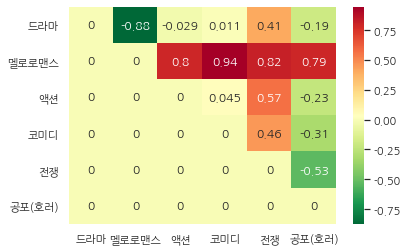

In [62]:
import matplotlib.pyplot as plt
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax